<a href="https://colab.research.google.com/github/fudmhz/TP5-Stackoverflow/blob/main/TP5_exploratory_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# TP5 Catégorisez automatiquement des questions

In this notebook we extract data from stackoverflow questions and perform an exploratory data analysis of the dataset.

The data can be originally found at: https://data.stackexchange.com/stackoverflow/query/new



**Questions we can ask:**
* Is all the text in english?
* Is the tagging correct (in other words, can we use it as ground truth?)
* What is the frequency of tags
* For a fixed tag, can we observe a pattern in the words used for writing the text or title? 

# Problem definition:

In this exercise our objective is to suggest the tags for a stackoverflow question.

Ideally we should be able to decide a tag for the user based upon only the available input when creating a question, which is the Title and the Text. 

Since the user that creates the question can input an arbitrary value we must chose to either restrict the problem or work with this loosened version.

In this notebook we explore the possibility of solving tag suggestion by two approaches: in a supervised manner and unsuppervised. 

The supervised case can be treated as a multiclass classification problem by restricting the number of tags to a fixed set and training a supervised method to generate a prediction. 

To obtain tag suggestions based on an unsupervised approach we need to detect the patterns and clusters present in different representation spaces of our data and depending of the way the method is applied, further process the data to obtain a prediction. 

Having established our goals, our exploratory analisys must verify the feasibility of treating the problem as a multiclass classification problem, explore the distribution of data such that we avoid unwated biases, analyse the need for preprocessing, and more generally study the complexity of the dataset and the computational limits imposed on the methods we will employ given the available resources.


# First exploration: 50k posts containining Title, tags and text
 
We download 50K random posts into a csv from the stackoverflow dataset. 

In [ ]:
file_0 = '1yAPuhmfgn43oeRkoU8wHafdPVNGavV5Q'

file_a = '138rhyaKejrGjENJHjsrjub6B14eEbh4B'

file_1 = '1xOY-DGZZitqMQMS9CpE6lrSY4_8rvQ_g'

from google_drive_downloader import GoogleDriveDownloader as gdd

data_path = os.path.join('.','data')

gdd.download_file_from_google_drive(file_id=file_1,
                                    dest_path=data_path,
                                    unzip=True)
# remove .zip data
!rm -rf 'data'

Unzipping...Done.


The dataset also contains all the used Tags and their overall counts:

In [ ]:
# downlaod and unzip tags counts
file_tags = '1hSd9bgE97l9lK-pkSK13CRGPIF9O3Q0F'

data_path = os.path.join('.','data')

gdd.download_file_from_google_drive(file_id=file_tags,
                                    dest_path=data_path,
                                    unzip=True)
# remove .zip data
!rm -rf 'data'

Unzipping...Done.


# 1. Exploratory analysis:



In [ ]:
df = pd.read_csv('PostSample_1.csv')

In [ ]:
df.head(10)

,Id,Body,Title,Tags,CreationDate,Score
0,1829,<p>I've got a menu in Python. That part was ea...,How do I make a menu that does not require the...,<python>,2008-08-05 02:39:23,27
1,3448,"<p>I've noticed a lot of sites, SO included, u...",Is it acceptable for invalid XHTML?,<xhtml><markup>,2008-08-06 14:21:18,21
2,8214,<p>How are you instrumenting your UI's? In the...,Instrumenting a UI,<wpf><user-interface><instrumentation>,2008-08-11 21:00:40,8
3,10919,<p>Usually when I'm creating indexes on tables...,How do you measure SQL Fill Factor value,<sql-server><fillfactor>,2008-08-14 12:07:27,8
4,11127,"<p>In a C++ Windows (XP and NT, if it makes a ...",In C++/Windows how do I get the network name o...,<c++><windows-xp><networking><windows-nt>,2008-08-14 14:37:27,8
5,13396,"<p>I love list comprehensions in Python, becau...",Replacement for for... if array iteration,<.net><python><arrays><loops><iteration>,2008-08-16 22:28:39,12
6,18298,<p>I cannot figure out how to change the title...,How do I change the title bar icon in Adobe AIR?,<apache-flex><air>,2008-08-20 16:15:55,1
7,19604,<p>What is the best Image Manager to integrate...,Best TinyMce editor Image Manager / File uploa...,<asp.net><asp.net-mvc><.net-2.0>,2008-08-21 10:53:54,28
8,20034,"<p><a href=""http://en.wikipedia.org/wiki/Proje...",Is Project Darkstar Realistic?,<java><concurrency><distributed>,2008-08-21 14:13:11,26
9,20386,<p>What are all the possible ways in which we ...,Memory leaks in .NET,<.net><optimization><memory-leaks>,2008-08-21 16:11:34,20


## 1.1 Tag analysis

Tags are written between less-than and greather-than signs on a single string.To work with individual tags we first have to process them using regex and create a list of tags that can be manipulated.

In [ ]:
# separate tags into a list of tags using a lambda function
get_tags = lambda x: re.findall("\<(.*?)\>", x)

df['Tags'] = df['Tags'].apply(get_tags)

df.head()


,Id,Body,Title,Tags,CreationDate,Score
0,1829,<p>I've got a menu in Python. That part was ea...,How do I make a menu that does not require the...,[python],2008-08-05 02:39:23,27
1,3448,"<p>I've noticed a lot of sites, SO included, u...",Is it acceptable for invalid XHTML?,"[xhtml, markup]",2008-08-06 14:21:18,21
2,8214,<p>How are you instrumenting your UI's? In the...,Instrumenting a UI,"[wpf, user-interface, instrumentation]",2008-08-11 21:00:40,8
3,10919,<p>Usually when I'm creating indexes on tables...,How do you measure SQL Fill Factor value,"[sql-server, fillfactor]",2008-08-14 12:07:27,8
4,11127,"<p>In a C++ Windows (XP and NT, if it makes a ...",In C++/Windows how do I get the network name o...,"[c++, windows-xp, networking, windows-nt]",2008-08-14 14:37:27,8


**Different names for the same tag**: 
The database offers a list of tag synonims. Is it already applied to our data?


SELECT ALL * FROM TagSynonyms 
 

### 1.1.1 Tag histogram

An important statistic that we can extract from our dataset is the tag frequency on our dataset. 

#### Stack overflow full tag data of top 1000 occuring tags

In [ ]:
df_tags = pd.read_csv('Query1000Tags.csv')
df_tags.head()

,Id,TagName,Count,ExcerptPostId,WikiPostId,IsModeratorOnly,IsRequired
0,3,javascript,2371297,3624960.0,3607052.0,NaN,NaN
1,16,python,1944488,3624965.0,3607014.0,NaN,NaN
2,17,java,1843540,3624966.0,3607018.0,NaN,NaN
3,9,c#,1536191,3624962.0,3607007.0,NaN,NaN
4,5,php,1435275,3624936.0,3607050.0,NaN,NaN


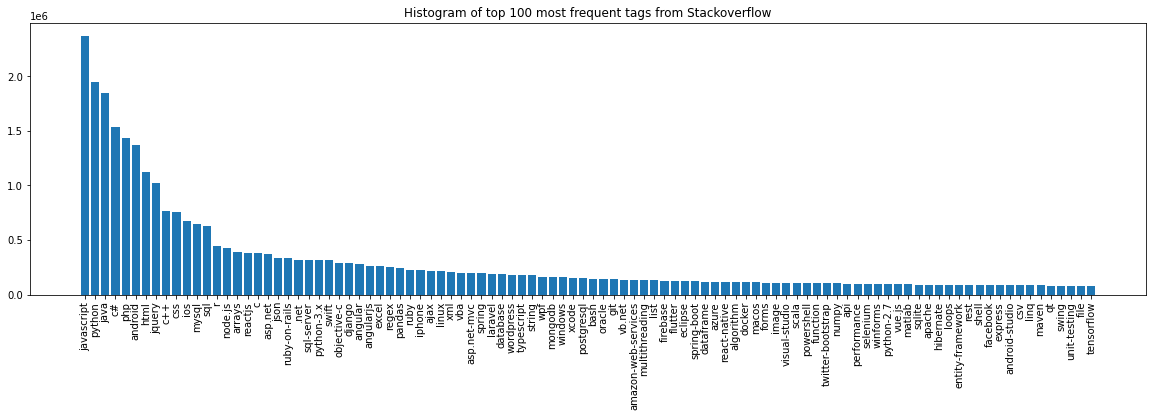

In [ ]:
# display histogram of full tag frequency dataset
n_tags = 100
plt.figure(figsize = (20, 5))
plt.bar((df_tags.TagName).to_numpy()[:n_tags],(df_tags.Count).to_numpy()[:n_tags])
plt.xticks(rotation = 'vertical')
plt.title(('Histogram of top {} most frequent tags from Stackoverflow').format(n_tags))
plt.show()

#### Validating our dataset sampling: 

Since the total dataset size is gigantic we need to have a method of detecting if the sampling of the dataset reflects the total dataset statistics. 
For instance, sampling the dataset on a specific timeframe can lead to a different histogram where a tag is not present.

We can compare statistics of tag frequency from the full dataset and from our subset of tags.

#### Statistics using subset of comments

In [ ]:
tag_array = df['Tags'].to_numpy()

In [ ]:
tag_dict = {}
for tag_list in tag_array:
  for tag in tag_list:
    if tag in tag_dict:
      tag_dict[tag] += 1
    else:
      tag_dict[tag] = 1

In [ ]:
tag_dict = dict(sorted(tag_dict.items(), key=lambda item: item[1], reverse = True))

Now let's look at the histogram of the 100 most frequent tags

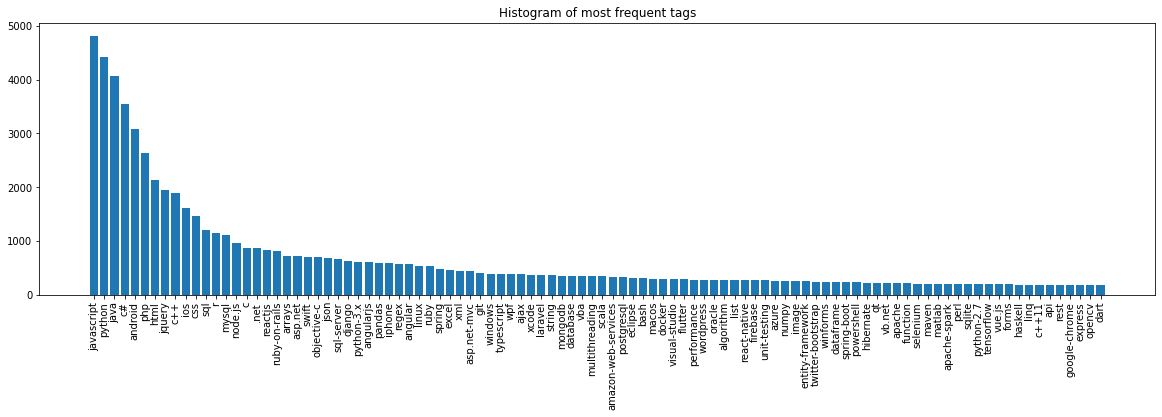

In [ ]:
n_tags = 100
plt.figure(figsize = (20, 5))
plt.bar(list(tag_dict.keys())[:n_tags],list(tag_dict.values())[:n_tags])
plt.xticks(rotation = 'vertical')
plt.title('Histogram of most frequent tags')
plt.show()

**Important:** We can visually observe that the histogram do not differ much from the total stackoverflow statistics.  

Now let's look at the histogram of the 100 less frequent tags

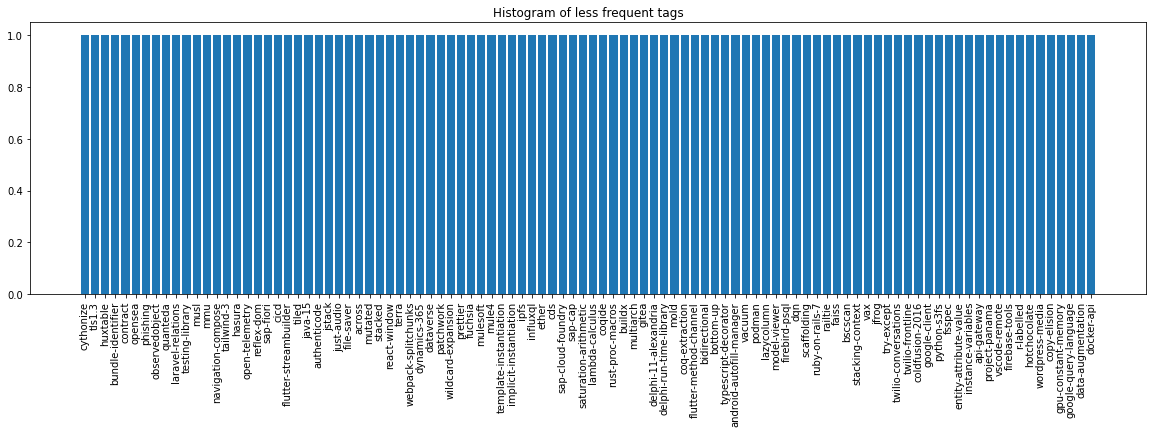

In [ ]:
n_tags = 100
plt.figure(figsize = (20, 5))
plt.bar(list(tag_dict.keys())[-n_tags:],list(tag_dict.values())[-n_tags:])
plt.xticks(rotation = 'vertical')
plt.title('Histogram of less frequent tags')
plt.show()

We can observe that that the distribution of tags is unequal: some tags are much more represented than others. The following plot contains the histogram of all tags.

[]

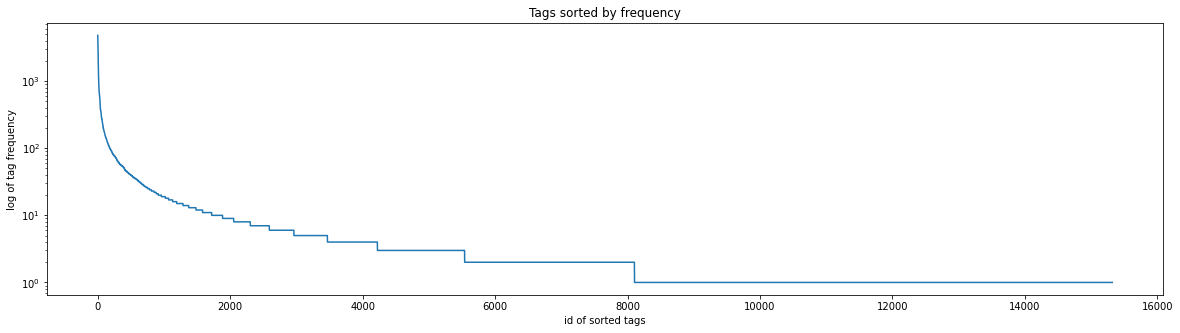

In [ ]:
fig = plt.figure(figsize = (20, 5))
ax = fig.add_subplot()
ax.plot(range(len(tag_dict)), list(tag_dict.values()))
ax.set_yscale('log')
ax.set_title('Tags sorted by frequency')
ax.set_xlabel('id of sorted tags')
ax.set_ylabel('log of tag frequency')
plt.plot()

### 1.1.2 Tags per question

Now we plot the number of tags per question and check for the presence of questions without tags. We observe that there are no questions with more than 5 tags.

In [ ]:
# check if there is a question with more than 5 tags
for tags in tag_array:
   if len(tags) > 5: 
     print('higher than 5') 

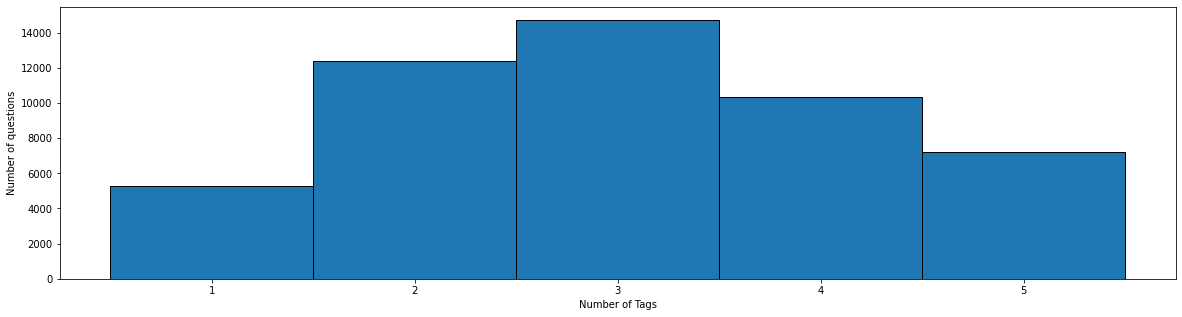

In [ ]:
plt.figure(figsize = (20, 5))
plt.hist([len(tags) for tags in tag_array],  bins=np.arange(0,6)+0.5, ec="k")  
plt.ylabel('Number of questions')
plt.xlabel('Number of Tags')
plt.show()

### 1.1.3 Tags timeline

Here we analyse the evolution of tag frequency on our dataset according to their timestamp. For instance, as programming languages popularities are dynamic, we should observe a increase or decrease according to each year usage among programmers. 

In [ ]:
# set number of top tags to analyse 
n = 10
top_n = [tag for idx, tag in enumerate(tag_dict) if idx < n]

# lambda function to extract year given standard dataset format and a specific tag
get_year = lambda df, name: [date[:4] for date in df[[name in tags for tags in df.Tags]].CreationDate.to_numpy()]

# list containing dicts of tag occurence per year
tags_to_year = []
for tag in top_n:
  tags_to_year.append(Counter(get_year(df, tag)))

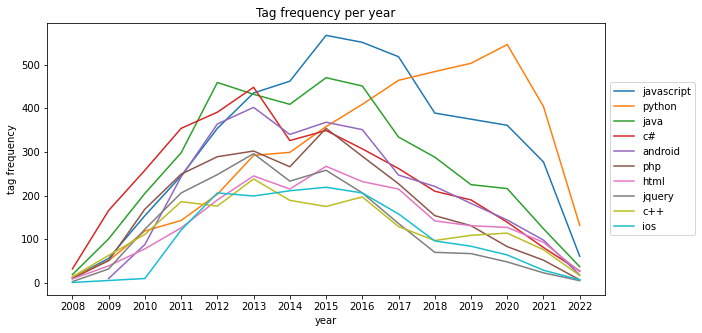

In [ ]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()
for idx, tag in enumerate(top_n):
  ax.plot(list(tags_to_year[idx].keys()), list(tags_to_year[idx].values()))
ax.set_title('Tag frequency per year')
ax.set_xlabel('year')
ax.set_ylabel('tag frequency')
ax.legend(top_n , bbox_to_anchor=(1.0,0.5) , loc="center left")

fig.show()

Simply counting the number of tags used on each year can be misleading since the total number of tags can increase but the relative proportion of a tag can decrease. Note that for the current year the number of 2022 the number of questions is still increasing and as such the drop in the graph does not mean the usage is decreasing! 

Normalizing the tag count by the total number of questions (note that a tag can appear on multiple questions) on each year offers the visualization of the popularity of a tag on a given year.

In [ ]:
# get questions count for each year
annual_question_count = Counter([date[:4] for date in df.CreationDate.to_numpy()])

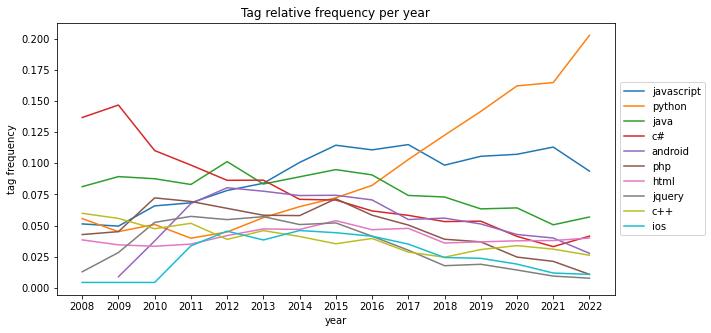

In [ ]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()
for idx, tag in enumerate(top_n):
  year_list = list(tags_to_year[idx].keys())
  val_list = list(tags_to_year[idx].values())
  values = [val/annual_question_count[year] for val, year in zip(val_list, year_list)]
  ax.plot(list(tags_to_year[idx].keys()), values)
ax.set_title('Tag relative frequency per year')
ax.set_xlabel('year')
ax.set_ylabel('tag frequency')
ax.legend(top_n , bbox_to_anchor=(1.0,0.5) , loc="center left")

fig.show()

Interestingly now we can see that althoug some tags increased their appearence over a year they actually decreased in popularity in the following year.

### 1.1.4 Question score

One of the attributes of the dataset is the question score, which is defined as the difference between upvotes and downvotes of a question. It is interesting to observe if the observations already done change significantly when we take into account questions that have a positive score higher than a threshold value. 



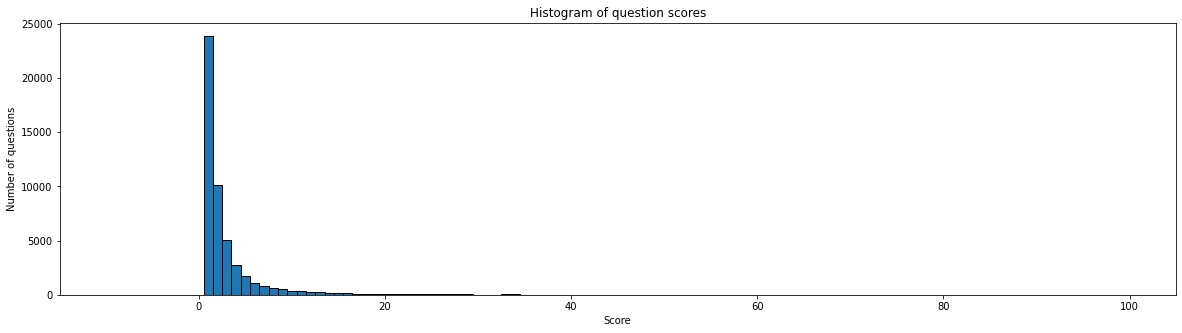

In [ ]:
score_array = df['Score'].to_numpy()
plt.figure(figsize = (20, 5))
plt.hist(score_array,  bins=np.arange(-10,100)+0.5, ec="k")  
plt.xticks(rotation = 'horizontal')
plt.title('Histogram of question scores')
plt.ylabel('Number of questions')
plt.xlabel('Score')
plt.show()

We observe that most of the questions have a score greater than zero. Questions that have score zero tend are the most common and scores lower than zero do not tend to be present. 

In the cells below we run some of the exploratory scripts again to observe the influence of the score over data.

In [ ]:
def score_threshold_tag_resutlts(tr_score = 1):
  # set threshold for score
  tag_array_a = df[df.Score >= tr_score]['Tags'].to_numpy()
  tag_array_b = df[df.Score < tr_score]['Tags'].to_numpy()
  ntags_a = len(df[df.Score >= tr_score])
  ntags_b = len(df[df.Score < tr_score])

  print("There are {} questions with score greater or equal than {}".format(ntags_a, tr_score))
  print("There are {} questions with score less or equal than {}".format(ntags_b, tr_score))
  tag_dict_a = {}
  for tag_list in tag_array_a:
    for tag in tag_list:
      if tag in tag_dict_a:
        tag_dict_a[tag] += 1
      else:
        tag_dict_a[tag] = 1

  tag_dict_b = {}
  for tag_list in tag_array_b:
    for tag in tag_list:
      if tag in tag_dict_b:
        tag_dict_b[tag] += 1
      else:
        tag_dict_b[tag] = 1

  tag_dict_a = dict(sorted(tag_dict_a.items(), key=lambda item: item[1], reverse = True))
  tag_dict_b = dict(sorted(tag_dict_b.items(), key=lambda item: item[1], reverse = True))
  n_tags = 50
  fig, axs = plt.subplots(1, 2,figsize = (20,5))
  axs[0].bar(list(tag_dict_a.keys())[:n_tags],list(tag_dict_a.values())[:n_tags])
  axs[0].title.set_text('Tag histogram of questions with score greater or equal than {}'.format(tr_score))

  axs[1].bar(list(tag_dict_b.keys())[:n_tags],list(tag_dict_b.values())[:n_tags], color='orange')
  axs[1].title.set_text('Tag histogram of questions with score less than {}'.format(tr_score))



  for ax in fig.axes:
      plt.sca(ax)
      plt.xticks(rotation=90)

  plt.show()
  fig, axs = plt.subplots(1, 2,figsize = (20,5))
  axs[0].hist([len(tags) for tags in tag_array_a],  bins=np.arange(0,6)+0.5, ec="k")  
  axs[0].title.set_text('Number of questions with score greater or equal than {}'.format(tr_score))
  axs[0].set_xlabel('Number of Tags')
  axs[0].set_ylabel('Number of Questions')


  axs[1].hist([len(tags) for tags in tag_array_b],  bins=np.arange(0,6)+0.5, ec="k", color='orange')  
  axs[1].title.set_text('Number tags per questions with score less than {}'.format(tr_score))
  axs[1].set_xlabel('Number of Tags')
  axs[1].set_ylabel('Number of Questions')

  plt.show()

There are 50000 questions with score greater or equal than 1
There are 0 questions with score less or equal than 1


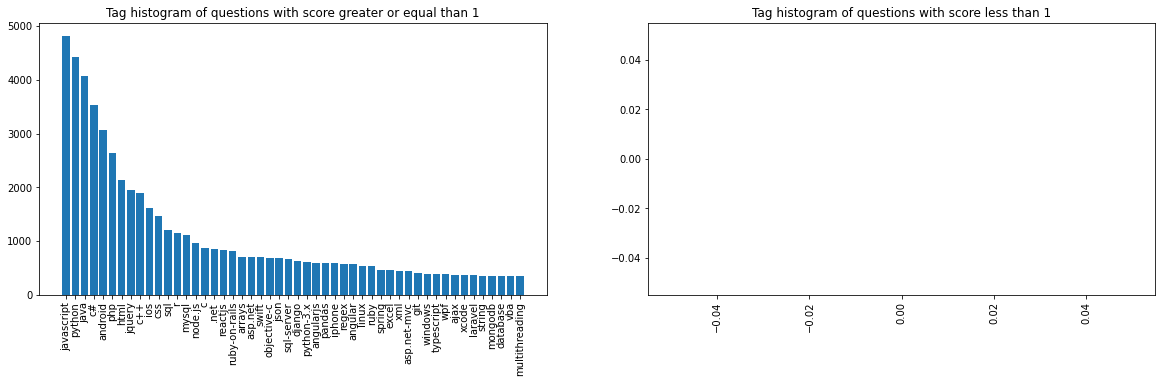

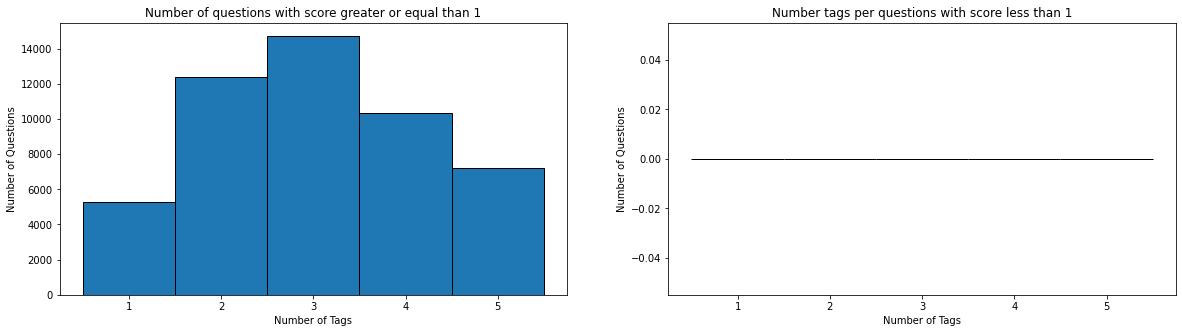

In [ ]:
score_threshold_tag_resutlts(1)

There are 3491 questions with score greater or equal than 10
There are 46509 questions with score less or equal than 10


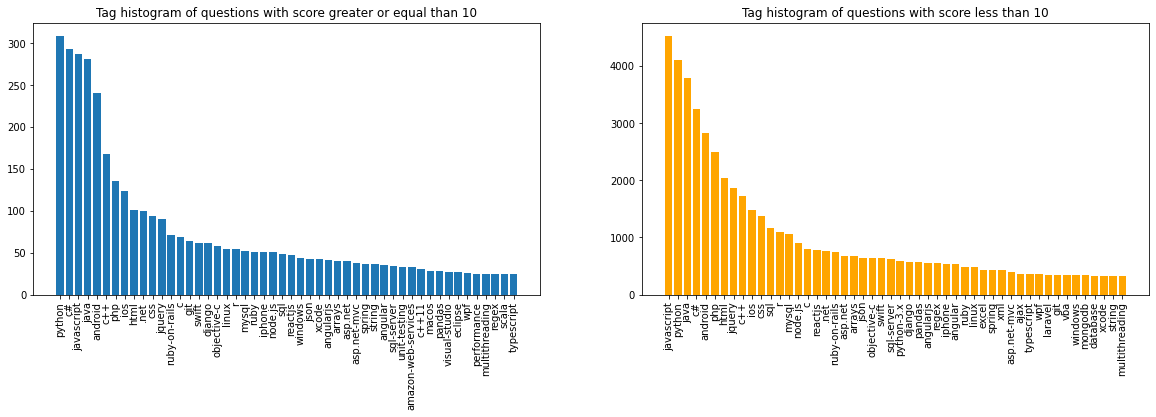

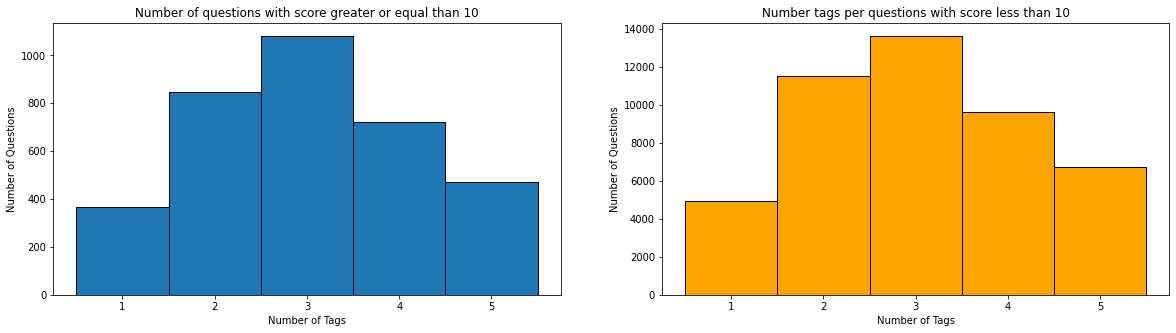

In [ ]:
score_threshold_tag_resutlts(10)

We observe that separating our data according to the score does not drastically change the statistics of our subset at first glance. From the analisys we can infer that questions with greater score tend to have slightly more tags than questions with less score, but we leave further analisys of the score out of scope.

## 2. Title analysis 

The titles of questions seem to be a good place to analyse the feseability of a applying different algorithms to our problem.


### 2.1 Word cloud of titles

Word clouds are a good and informative way of visually observing raw available text data to 

  0%|          | 0/50000 [00:00<?, ?it/s]

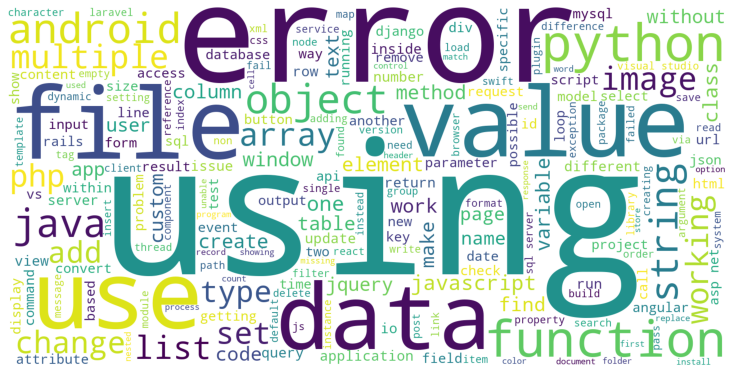

In [ ]:
# Python program to generate WordCloud 
  
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
from tqdm.auto import tqdm # loading bar
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in tqdm(df.Title[~df.Title.isnull()]):
      
  # typecaste each val to string 
  val = str(val) 

  # split the value 
  tokens = val.split() 
    
  # Converts each token into lowercase 
  for i in range(len(tokens)): 
      tokens[i] = tokens[i].lower() 
    
  comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1600, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (16, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

# Check for duplicate terms written differently

Here we check the robustness of our dataset so we know in advance what precautions need to be taken when preprocessing the dataset.

We observe that the dataset is not fully robust in the sense of spelling the same composed word. For instance the word visual-studio appears as 'visual studio' but also as 'visual-studio'. This has to be dealt in preprocessing.

In [ ]:
tag_dict['visual-studio']

287

In [ ]:
for title in df.Title.to_list():
  #print(title)
  if 'visual-studio' in title.lower():
    print(title)

In [ ]:
for title in df.Title.to_list()[:100]:
  #print(title)
  if 'visual' in title.lower():
    print(title)

What is the difference between Build Solution and Batch Build in Visual Studio 2008?


In [ ]:
count = 0
for text in df.Body.to_list():
  #print(title)
  if 'visual-studio' in text.lower():
    print('***body of question:***')
    print(text)
    count+=1
  if count == 2: 
    break

***body of question:***
<p>This is a question related to a previous question I posted (see <a href="https://stackoverflow.com/questions/2251983/batch-files-in-visual-studio-2008">here</a>).<br/>
I need to configure a .csproj file to copy some files from a directory to another one (let me call them SOURCE and DESTINATION). I also need to change the SOURCE path depending from the configuration I'm using. For example, if I compile my project in Debug mode, the SOURCE path must contain a subfolder called Debug.<br/>
I tried the solution proposed by Schmitt in the previous post, using $(ConfigurationName) to set the dynamic directory into the SOURCE path. When I opened the solution containing that project, a list of links to the source files appeared in the main tree of the project and they were correctly related to the Debug mode. But when I changed to the Release mode, I saw that the path of the linked source files were set again to the Debug version.<br/>
Is there a way to specify a para

# **3 Title Pre-processing**

Here we process the title into a bow representation. This allows for a more in depth analisys of our data such that we can process it into features that can be better dealt by machine learning algorithms.

In [ ]:
df.Title.to_list()[:10]

['How do I make a menu that does not require the user to press [enter] to make a selection?',
 'Is it acceptable for invalid XHTML?',
 'Instrumenting a UI',
 'How do you measure SQL Fill Factor value',
 "In C++/Windows how do I get the network name of the computer I'm on?",
 'Replacement for for... if array iteration',
 'How do I change the title bar icon in Adobe AIR?',
 'Best TinyMce editor Image Manager / File upload for Asp.net Mvc',
 'Is Project Darkstar Realistic?',
 'Memory leaks in .NET']

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import nltk.stem as stemmer
from nltk.stem.porter import *
import nltk
nltk.download('wordnet')
nltk.download('punkt')

# instantiate stemmer
stemmer = PorterStemmer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from nltk import word_tokenize
from nltk.tokenize import MWETokenizer

# add exceptions to tokenizer
tokenizer = nltk.tokenize.MWETokenizer()
tokenizer.add_mwe(('c', '#'))

In [ ]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))


def preprocess(text):
    result = []
    # remove ponctuation but keep relevant data
    initial_preprocess = lambda text : "".join([char for char in text if char not in '!"$%&\'()*,./:;<=>?@[\\]^_`{|}~']).lower()
    tokens = tokenizer.tokenize(word_tokenize(initial_preprocess(text)))
    for token in tokens:
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
processed_titles = df.Title.map(preprocess)

In [ ]:
processed_titles

0               [menu, requir, user, press, enter, select]
1                                 [accept, invalid, xhtml]
2                                         [instrument, ui]
3                              [measur, sql, factor, valu]
4                                 [c++window, network, im]
                               ...                        
49995                                     [array, element]
49996    [cefsharp, winform, 101, read, cooki, browser,...
49997                        [line, line, text, csv, file]
49998    [execut, predefin, docker, command, java, appl...
49999                    [sql, count, instanc, occurr, id]
Name: Title, Length: 50000, dtype: object

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_titles)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 enter
1 menu
2 press
3 requir
4 select
5 user
6 accept
7 invalid
8 xhtml
9 instrument
10 ui


In [ ]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [ ]:
title_bow_corpus = [dictionary.doc2bow(title) for title in processed_titles]


In [ ]:
def sample_nlp_pipeline(sample_idx):
  print('sample idx:', sample_idx)

  print('saple tags:', df.Tags.to_list()[sample_idx])
  print('\nprocessing pipeline: \n')
  print('sample title:', df.Title.to_list()[sample_idx])
  print('preprocessed title:', processed_titles[sample_idx])
  print('bow_corpus of title:', bow_corpus[sample_idx])
  print('bag of words equivalence: \n')
  bow_doc_sample = bow_corpus[sample_idx]
  for i in range(len(bow_doc_sample)):
      print("Word {} (\"{}\") appears {} time.".format(bow_doc_sample[i][0], 
                                                dictionary[bow_doc_sample[i][0]], bow_doc_sample[i][1]))


In [ ]:
sample_nlp_pipeline(1)

sample idx: 1
saple tags: ['xhtml', 'markup']

processing pipeline: 

sample title: Is it acceptable for invalid XHTML?
preprocessed title: ['accept', 'invalid', 'xhtml']
bow_corpus of title: [(6, 1), (7, 1)]
bag of words equivalence: 

Word 6 ("accept") appears 1 time.
Word 7 ("invalid") appears 1 time.


### Question: How many topics should we use?

In [ ]:
title_lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=500, id2word=dictionary, passes=2, workers=2)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [ ]:
for idx, topic in title_lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

In [ ]:
def infer_topic_score(sample_idx):
  for index, score in sorted(lda_model[bow_corpus[sample_idx]], key=lambda tup: -1*tup[1]):
      print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

In [ ]:
idx = 1
sample_nlp_pipeline(idx)
infer_topic_score(idx)

sample idx: 1
saple tags: ['xhtml', 'markup']

processing pipeline: 

sample title: Is it acceptable for invalid XHTML?
preprocessed title: ['accept', 'invalid', 'xhtml']
bow_corpus of title: [(6, 1), (7, 1)]
bag of words equivalence: 

Word 6 ("accept") appears 1 time.
Word 7 ("invalid") appears 1 time.

Score: 0.33399999141693115	 
Topic: 0.669*"accept" + 0.203*"uilabel" + 0.012*"string" + 0.012*"php" + 0.006*"type" + 0.005*"io" + 0.005*"text" + 0.005*"function" + 0.004*"valu" + 0.004*"similar"

Score: 0.33399999141693115	 
Topic: 0.428*"tri" + 0.254*"invalid" + 0.108*"error" + 0.087*"macro" + 0.079*"go" + 0.025*"paragraph" + 0.006*"data" + 0.001*"type" + 0.001*"user" + 0.001*"class"


In [ ]:
idx = 11010
sample_nlp_pipeline(idx)
print("\n#####\nprediction:\n")
infer_topic_score(idx)

sample idx: 11010
saple tags: ['mysql', 'string', 'add']

processing pipeline: 

sample title: Add string to mysql result
preprocessed title: ['add', 'string', 'mysql', 'result']
bow_corpus of title: [(361, 1), (391, 1), (666, 1), (835, 1)]
bag of words equivalence: 

Word 361 ("mysql") appears 1 time.
Word 391 ("string") appears 1 time.
Word 666 ("add") appears 1 time.
Word 835 ("result") appears 1 time.

#####
prediction:


Score: 0.39993616938591003	 
Topic: 0.766*"mysql" + 0.073*"php" + 0.047*"short" + 0.034*"sit" + 0.023*"-" + 0.013*"databas" + 0.012*"creat" + 0.009*"add" + 0.002*"socket" + 0.002*"connect"

Score: 0.2008638083934784	 
Topic: 0.491*"tabl" + 0.277*"result" + 0.170*"order" + 0.027*"-" + 0.012*"sql" + 0.009*"coldfus" + 0.005*"mysql" + 0.002*"join" + 0.002*"php" + 0.001*"updat"

Score: 0.2003999948501587	 
Topic: 0.894*"string" + 0.044*"lookup" + 0.017*"-" + 0.011*"valu" + 0.009*"php" + 0.007*"file" + 0.006*"android" + 0.002*"c_#" + 0.002*"element" + 0.001*"data"


In [ ]:
# test on unseen data
unseen_title = 'How can I declare a struct in java'
bow_vector = dictionary.doc2bow(preprocess(unseen_title))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topcic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.2510105073451996	 Topcic: 0.397*"declar" + 0.165*"cursor" + 0.137*"prop" + 0.092*"”" + 0.087*"“"
Score: 0.25049999356269836	 Topcic: 0.451*"avoid" + 0.362*"struct" + 0.111*"part" + 0.019*"array" + 0.014*"pointer"
Score: 0.24998947978019714	 Topcic: 0.638*"java" + 0.128*"11" + 0.092*"timezon" + 0.055*"implicit" + 0.037*"strip"


# **4 Body Pre-processing**

Here we process the body of questions into a bow representation. Applying the same pipeline that we used for the Title is not straightforward since the text contains different sentences. 

In [ ]:
df.Body.to_list()[:10]

['<p>I\'ve got a menu in Python. That part was easy. I\'m using <code>raw_input()</code> to get the selection from the user. </p>\n\n<p>The problem is that <code>raw_input</code> (and input) require the user to press <kbd>Enter</kbd> after they make a selection. Is there any way to make the program act immediately upon a keystroke? Here\'s what I\'ve got so far:</p>\n\n<pre><code>import sys\nprint """Menu\n1) Say Foo\n2) Say Bar"""\nanswer = raw_input("Make a selection&gt; ")\n\nif "1" in answer: print "foo"\nelif "2" in answer: print "bar"\n</code></pre>\n\n<p>It would be great to have something like</p>\n\n<pre><code>print menu\nwhile lastKey = "":\n    lastKey = check_for_recent_keystrokes()\nif "1" in lastKey: #do stuff...\n</code></pre>\n',
 "<p>I've noticed a lot of sites, SO included, use XHTML as their mark-up language and then fail to adhere to the spec. Just browsing the source for SO there are missing closing tags for paragraphs, invalid elements, etc.</p>\n\n<p>So should to

In [ ]:
processed_Bodies = df.Body.map(preprocess)

In [ ]:
processed_Bodies[:10]

0    [pive, get, menu, python, easi, im, coderawinp...
1    [pive, notic, lot, sit, includ, use, xhtml, ma...
2    [phow, instrument, ui, past, ive, read, peopl,...
3    [pusual, im, creat, index, tabl, gener, guess,...
4    [pin, c++, window, xp, nt, make, differ, appli...
5    [pi, love, list, comprehens, python, concis, r...
6    [pi, figur, chang, titl, bar, icon, icon, furt...
7    [pwhat, best, imag, manag, integr, tinymc, edi...
8    [pa, hrefhttpenwikipediaorgwikiprojectdarkstar...
9    [pwhat, possibl, way, memori, leak, netp, pi, ...
Name: Body, dtype: object

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_titles)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 enter
1 menu
2 press
3 requir
4 select
5 user
6 accept
7 invalid
8 xhtml
9 instrument
10 ui


In [ ]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [ ]:
bow_corpus = [dictionary.doc2bow(title) for title in processed_titles]


In [ ]:
def sample_nlp_pipeline(sample_idx):
  print('sample idx:', sample_idx)

  print('saple tags:', df.Tags.to_list()[sample_idx])
  print('\nprocessing pipeline: \n')
  print('sample title:', df.Title.to_list()[sample_idx])
  print('preprocessed title:', processed_titles[sample_idx])
  print('bow_corpus of title:', bow_corpus[sample_idx])
  print('bag of words equivalence: \n')
  bow_doc_sample = bow_corpus[sample_idx]
  for i in range(len(bow_doc_sample)):
      print("Word {} (\"{}\") appears {} time.".format(bow_doc_sample[i][0], 
                                                dictionary[bow_doc_sample[i][0]], bow_doc_sample[i][1]))


In [ ]:
sample_nlp_pipeline(1)

sample idx: 1
saple tags: ['xhtml', 'markup']

processing pipeline: 

sample title: Is it acceptable for invalid XHTML?
preprocessed title: ['accept', 'invalid', 'xhtml']
bow_corpus of title: [(6, 1), (7, 1)]
bag of words equivalence: 

Word 6 ("accept") appears 1 time.
Word 7 ("invalid") appears 1 time.


### Question: How many topics should we use?